<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

import scipy
from scipy.spatial import distance
from scipy import signal

import dynamics
from dynamics import*

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/cruiser/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Real Game Dynamics analysis  
The real game dynamcis shows huge difference performance in speed, stability of results, and also statistics of strategy 

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

## Game Performance analysis

## Performance analysis
differ by speed, stability and final results on different sizes of arena, both for intra, and extrapolation

### analysis on early stage
**much faster learning speed of pretrained net on small size of arena, compare resutls on the first iteration for small and large size of arena. That rise in speed in small size is not necessarlily related to decoding, but should relie more dynamics **

In [2]:
class PretrainTest():
    def __init__(self, weight_write, holes = 0, inputs_type = (1, 0)):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_write
            
    def loadweight(self, weight_load):
#       need to take the state dict as a new dict for updating 
        net_dict = torch.load(weight_load)
        list_modules = [('h2h', net_dict['h2h']), ('a2h', net_dict['a2h']), ('i2h', net_dict['i2h']), ('r2h', net_dict['r2h']), ('bh', net_dict['bh'])]
        select_dict = OrderedDict(list_modules)
        net = self.pregame.net.state_dict()
        net.update(select_dict)
        self.pregame.net.load_state_dict(net)
        torch.save(self.pregame.net.state_dict(), self.weight) 
    
        
    def pretrain(self, trial, weight = None, lr = 1e-5, pretrain = True):  
        # start a pretrained game  
        self.pregame.net.cuda()
        if pretrain == True:
            lr = float(lr)
            if weight != None:
                self.pregame.net.load_state_dict(torch.load(weight))
            self.pregame.fulltrain(lr_rate = lr, trials = int(1e3), batchsize = 4)
        print ('pretrain end', torch.norm(self.pregame.net.h2h))
        if pretrain == True:
            torch.save(self.pregame.net.state_dict(), self.weight[:-1]+'{}'.format(trial))
        else:
            torch.save(self.pregame.net.state_dict(), self.weight+'{}'.format(trial))
        if pretrain == True and trial <= 10:
            self.weight = self.weight[:-1]+'{}'.format(trial)
        elif pretrain == True and trial > 10:
            self.weight = self.weight[:-2]+'{}'.format(trial)
        elif pretrain == False:
            self.weight = self.weight +'{}'.format(trial)
            
    def decode(self, weight = None):
        if weight != None:
            self.pregame.net.load_state_dict(torch.load(weight))
        else:
             self.pregame.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl,20, epsilon = 0.5, train_hidden = False, train_q = False, size_range=(15, 16), test = True) 
        def precision():
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0)[0])
            prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
            prec2 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1)[0])
            return (prec0 + prec1 + prec2)/3, (prec2 - prec0)
        print ('decode train finish')
        Prec, dif = precision()
        print ('decode end', Prec, 'dif decode', dif)
        return Prec, dif
        # q learning session 
    
        
    def qlearn(self, weight_read, weight_write, iterations = 5, save = True, size_train = np.arange(10, 51, 10), \
               size_test = [10, 30], train_only = False, test_only = False, noise = 0.3, h2o = True,
              k_action = 1, k_internal = 1, k_stim = 1):
        self.game.net.load_state_dict(torch.load(weight_read))
        if h2o == True:
            self.game.net.h2o = nn.Parameter(torch.randn(512, 4) * 0.01 * np.sqrt(2.0/(512 + 4)))
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        e_rate = [noise for r in range(iterations)] 
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        Rewards = []
        # q leanring phase
        for n,e in enumerate(e_rate):
            prob = np.ones(len(size_train)) 
            prob = prob/np.sum(prob)
            if test_only == False:
                self.game.experiment(rls_q, rls_sl, iterations = 50, epochs= 10, epsilon = e, size_range = size_train)    
                if save == True:
                    torch.save(self.game.net.state_dict(), weight_write + '_{}'.format(n))
            def testing(game):
                Rewards00 = Test(game, reward_control = 0, size = size_test[0], test = 1)
                Rewards01 = Test(game, reward_control = 1, size = size_test[0], test = 1)
                rewards_s = (np.sum(Rewards00) + np.sum(Rewards01))/2
                Rewards10 = Test(game, reward_control = 0, size = size_test[1], test = 2)
                Rewards11 = Test(game, reward_control = 1, size = size_test[1], test = 2)
                rewards_l = (np.sum(Rewards10) + np.sum(Rewards11))/2
                return rewards_s, rewards_l
            # load weight if test only is true 
            if test_only == True:
                self.game.net.load_state_dict(torch.load(weight_write))
            if train_only == False:
                rewards_s, rewards_l = testing(self.game)
            print (n, 'rewards_s',  rewards_s, 'rewards_l', rewards_l)
            Rewards.append((rewards_s, rewards_l))
        return Rewards
    
    def TestAllSizes(self, size_range = np.arange(5, 50, 5), k_action = 1, k_internal = 1, 
                    k_stim = 1, limit_set = 4, test_size = 1):
        self.game.net.load_state_dict(torch.load(self.weight))
        self.game.net.cpu()
        self.Performance = []
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        for size in size_range:
            Rewards0 = Test(self.game, reward_control = 0, size = size, limit_set = limit_set, test = test_size)
            Rewards1 = Test(self.game, reward_control = 1, size = size, limit_set = limit_set, test = test_size)
            self.Performance.append((Rewards0 + Rewards1)/2)

In [9]:
def performance_measure(size, test_size, trial = 202, \
                        shuffle = False, pretrain = False, random = False, k_action = 1, k_internal = 1, k_stim = 1, limit_set = 4):
    trials = 3
    performance = np.zeros((trials, 5))
    for iters1 in np.arange(trials):
        for iters2 in np.arange(1, 10):
            if shuffle == True:
                weight = 'weights_2_shuffle/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, iters1+3, iters2)
            if random == True:
                weight = 'weights_2_random/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, iters1+3, iters2)
            if pretrain == True:
                weight = 'weights2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, iters1+2, iters2)
            Pretest = PretrainTest(weight_write = weight)
            Pretest.TestAllSizes(size_range = [size], limit_set = limit_set, test_size = test_size)
            performance[iters1, iters2-5] = Pretest.Performance[0]
    print(np.max(performance, axis = 1))
    return performance
# performance_measure(0, 0, 10, 0)

## Learning History

## Generalization

In [11]:
performance10 = performance_measure(10, 0, trial = 204, k_action=1, k_internal=1, k_stim=1, pretrain = True)

performance30 = performance_measure(30, 1, trial = 204, k_action=1, k_internal=1, k_stim=1, shuffle = False, pretrain=True)

performance50 = performance_measure(50, 2, trial = 204, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

performance70 = performance_measure(70, 3, trial = 204, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

performance90 = performance_measure(90, 4, trial = 204, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

[ 0.914649    0.72247768  0.9266307 ]
[ 0.49300664  0.58497735  0.80911788]
[ 0.08038289  0.07272204 -0.20772036]
[-0.14505663 -0.47861975 -0.5808235 ]
[-0.47132511 -0.61134132 -0.62752985]


In [45]:
performance10_2 = performance_measure(10, 0, trial = 399, k_action=1, k_internal=1, k_stim=1, pretrain = True)

performance30_2 = performance_measure(30, 1, trial = 399, k_action=1, k_internal=1, k_stim=1, shuffle = False, pretrain=True)

performance50_2 = performance_measure(50, 2, trial = 399, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

performance70_2 = performance_measure(70, 3, trial = 399, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

performance90_2 = performance_measure(90, 4, trial = 399, k_action=1, k_internal=1, k_stim=1, limit_set = 4, pretrain = True)

[0.92248575 0.92775971 0.86464312]
[-0.26638695  0.5382188   0.6097816 ]
[-0.53105335 -0.14635161 -0.08262334]
[-0.64453962 -0.26480227 -0.04513524]
[-0.68389514 -0.51243748 -0.54872709]


In [37]:
np.save('performance90', performance90)

In [41]:
np.save('performance_10_1', performance10)
np.save('performance_30_1', performance30)
# np.save('performance10_shuffle', performance10_s)
# np.save('performance50_shuffle', performance50_s)
np.save('performance_50_1', performance50)
# np.save('performance70_shuffle', performance70_s)
np.save('performance_70_1', performance70)
# np.save('performance90_shuffle_f', performance90_s_f)
np.save('performance_90_1', performance90)

In [46]:
np.save('performance_10_2', performance10_2)
np.save('performance_30_2', performance30_2)
# np.save('performance10_shuffle', performance10_s)
# np.save('performance50_shuffle', performance50_s)
np.save('performance_50_2', performance50_2)
# np.save('performance702shuffle', performance70_s)
np.save('performance_70_2', performance70_2)
# np.save('performance90_shuffle_f', performance90_s_f)
np.save('performance_90_2', performance90_2)

In [65]:
performance_10 = np.load('performance_10_1.npy')
performance_30 = np.load('performance_30_1.npy')
performance_50 = np.load('performance_50_1.npy') 
performance_70 = np.load('performance_70_1.npy') 
performance_90 = np.load('performance_90_1.npy')
performance_10_2 = np.load('performance_10_2.npy')
performance_30_2 = np.load('performance_30_2.npy')
performance_50_2 = np.load('performance_50_2.npy') 
performance_70_2 = np.load('performance_70_2.npy') 
performance_90_2 = np.load('performance_90_2.npy')
performance_10 = np.concatenate((performance_10, performance_10_2), axis = 0)
performance_30 = np.concatenate((performance_30, performance_30_2), axis = 0)
performance_50 = np.concatenate((performance_50, performance_50_2), axis = 0)
performance_70 = np.concatenate((performance_70, performance_70_2), axis = 0)
performance_90 = np.concatenate((performance_90, performance_90_2), axis = 0)
performance_g10 = np.max(performance_10, axis = 1)
performance_g30 = np.max(performance_30, axis = 1)
performance_g50 = np.max(performance_50, axis = 1) 
performance_g70 = np.max(performance_70, axis = 1) 
performance_g90 = np.max(performance_90, axis = 1)

In [66]:
# PG_s = [performance_g10_s, performance_g30_s, performance_g50_s, performance_g70_s, performance_g90_s]
# pG_s = np.concatenate(PG_s)
PG = [performance_g10, performance_g30, performance_g50, performance_g70, performance_g90]
pG = np.concatenate(PG)

In [67]:
performance_10

array([[ 0.90781511,  0.93652237,  0.96329207,  0.92052491,  0.92648432],
       [ 0.91792286,  0.96345104,  0.96926579,  0.93471096,  0.90596227],
       [ 0.9561858 ,  0.97065962,  0.92324865,  0.91592   ,  0.93365387],
       [ 0.68421067, -0.11349664, -0.16439503,  0.16381306,  0.92248575],
       [ 0.9075971 ,  0.88257277,  0.57032205,  0.92775971,  0.40752523],
       [ 0.83016976,  0.85926838,  0.65623779,  0.86021167,  0.86464312]])

In [68]:
PG

[array([0.96329207, 0.96926579, 0.97065962, 0.92248575, 0.92775971,
        0.86464312]),
 array([ 0.38521771,  0.52222303, -0.04578278, -0.26638695,  0.5382188 ,
         0.6097816 ]),
 array([ 0.03957431, -0.03178359, -0.32431379, -0.53105335, -0.14635161,
        -0.08262334]),
 array([-0.04569866, -0.21776189, -0.41834027, -0.64453962, -0.26480227,
        -0.04513524]),
 array([-0.08724338, -0.32935053, -0.64767309, -0.68389514, -0.51243748,
        -0.54872709])]

In [71]:
np.save('PG_Scaling_PosNet_2', PG)

In [58]:
performance = performance_measure(90, 4, trials = 5, k_action=1, k_internal=1, k_stim=1, limit_set = 16)

[ 0.63905325  0.27810651 -0.00591716 -0.08284024  0.20710059]


In [68]:
np.save('performance90_shuffle', performance)

In [81]:
performance = performance_measure(90, 4, trials = 5, k_action=1, k_internal=1, k_stim=1, limit_set = 16,
                                 pretrain = True)

[ 0.07100592 -0.28994083  0.3964497   0.18343195 -0.25443787]


In [82]:
np.save('performance90', performance)

In [83]:
performance = performance_measure(30, 1, trials = 5, k_action=1, k_internal=1, k_stim=1, pretrain = True)

[0.76 0.28 0.58 0.74 0.52]


In [84]:
np.save('performance30', performance)

### Performance 30 as reference

In [77]:
perform30 = np.load('performance30_shuffle.npy')
np.mean(perform30[perform30>0.0]) 

0.6187999999999999

In [85]:
perform30 = np.load('performance30.npy')
np.mean(perform30[perform30>0.0]) 

0.45875

### Performance 90 as test

In [78]:
perform90 = np.load('performance90_shuffle.npy')
np.mean(perform90[perform30>0.3])

-0.08001029071263185

In [86]:
perform90 = np.load('performance90.npy')
np.mean(perform90[perform30>0.3])

-0.1643655489809336

## Behaviour 
Check best of PosNet and echo Net

In [40]:
def performance_measure_fast(size, test_size,weight, limit_set = 4):
    Pretest = PretrainTest(weight_write = weight)
    Pretest.TestAllSizes(size_range = [size], limit_set = limit_set, test_size = test_size)
    performance = Pretest.Performance[0]
    print(performance)
    return performance

1.0 -1
-1 1.0


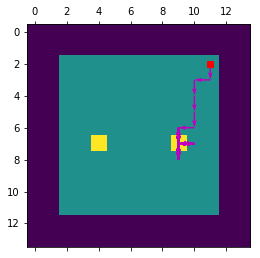

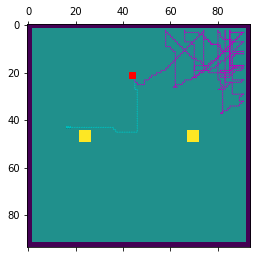

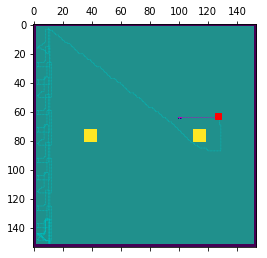

In [55]:
torch.manual_seed(np.random.randint(1e5))
hidden = torch.randn(1, 512)
size = 10
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint270_0_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
   
    if i == 0:
        plt.matshow(grid)
#         y1 = np.array([p[0] for p in Pos1])
#         x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')


size = 90
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint270_2_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

size = 150
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint270_2_9'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

  


In [64]:
weight ='weights2/rnn_1515tanh512_checkpoint270_0_9'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.338586410381


In [65]:
weight ='weights2/rnn_1515tanh512_checkpoint270_1_9'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.326832522684


In [44]:
weight ='weights2/rnn_1515tanh512_checkpoint270_2_9'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.285274294464


-1 1.0
1.0 -1


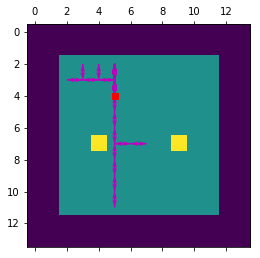

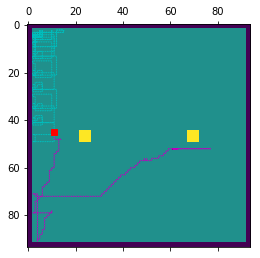

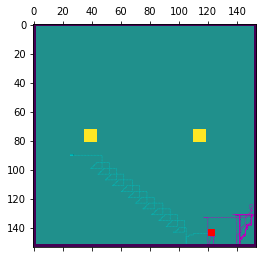

In [52]:
torch.manual_seed(np.random.randint(1e5))
hidden = torch.randn(1, 512)
size = 10
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint204_2_2'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
   
    if i == 0:
        plt.matshow(grid)
#         y1 = np.array([p[0] for p in Pos1])
#         x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')


size = 90
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint204_2_2'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

size = 150
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint204_2_2'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

  


In [56]:
weight ='weights2/rnn_1515tanh512_checkpoint204_2_2'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

0.0870237392145


In [57]:
weight ='weights2/rnn_1515tanh512_checkpoint204_2_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.174230570155


In [62]:
weight ='weights2/rnn_1515tanh512_checkpoint204_3_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.393822076685


In [63]:
weight ='weights2/rnn_1515tanh512_checkpoint204_4_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.4378698224852071


In [66]:
weight ='weights2/rnn_1515tanh512_checkpoint325_0_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.151597734291


1.0 1.0
-1 -1


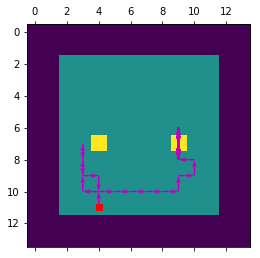

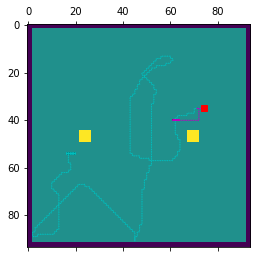

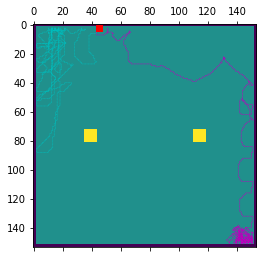

In [50]:
torch.manual_seed(np.random.randint(1e5))
hidden = torch.randn(1, 512)
size = 10
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint0_0_19'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
   
    if i == 0:
        plt.matshow(grid)
#         y1 = np.array([p[0] for p in Pos1])
#         x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')


size = 90
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint0_0_19'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    
size = 150
PC_traces = []
start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
for i in range(1):
    weight ='weights2/rnn_1515tanh512_checkpoint0_0_19'
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    grid = game.grid.grid.copy()
    Pos1, hidden1, dH1, Action, state1, reward1 = trajectory(game, start, reward_control = 0, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    Pos2, hidden2, dH2, Action, state2, reward2 = trajectory(game, start, reward_control = 1, size = size, test = size//10-1, init_hidden = False, hidden = hidden)
    print (reward1, reward2)
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'c')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

In [45]:
weight ='weights2/rnn_1515tanh512_checkpoint0_0_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

0.0859186713515


In [58]:
weight ='weights2/rnn_1515tanh512_checkpoint0_1_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

0.0750063909663


In [59]:
1weight ='weights2/rnn_1515tanh512_checkpoint0_2_19'
size = 90
test_size = size//10-1
perform =  performance_measure_fast(size, test_size, weight, limit_set = 4)

-0.271182105904


# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**